In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

# 训练

In [34]:
# xlearn 
import xlearn as xl

ffm_model = xl.create_ffm()
ffm_model.setTrain("../data1/train_interaction_ffm.txt")
# ffm_model.setValidate("../data1/valid_interaction_ffm.txt")

#  0. binary classification task
#  1. learning rate: 0.2
#  2. lambda: 0.002
#  3. metric: auc
ffm_model.fit(
    {'task':'binary', 'lr':0.02, 'lambda':0.002, 'metric': 'auc'}, 
    "../out/model_interaction_ffm"
)

# 预测

In [35]:
# xlearn
ffm_model.setTest("../data1/valid_interaction_ffm.txt")
ffm_model.setSigmoid()
ffm_model.predict("../out/model_interaction_ffm", "../out/pred_interaction_ffm.txt")

# 评分

In [36]:
import pandas as pd

pred = pd.read_table(
    '../out/pred_interaction_ffm.txt', 
    names = ['click']
)
valid = pd.read_table(
    '../out/valid.txt',
    names = ['user_id', 'photo_id', 'click']
)

In [37]:
valid['click'] = pred['click']

In [38]:
valid.to_csv('../out/pred.txt', index=False, header=False, sep='\t', float_format='%.6f')

In [39]:
%run evaluation_script.py ../out/pred.txt ../out/valid.txt

{'code': 0, 'message': 'validation success'}
{'code': 0, 'score': 0.49939241467257306, 'message': 'success'}


## 一个用户

In [8]:
# time戳转为0~23小时
def to_hour(time):
    return int(time/3600000)%24

In [9]:
# duration_time转为 0, 1~10, 11~20, 21~30, 31~40, 41~50, 51~60, >61

import math

def to_category(duration_time):
    r = math.ceil(duration_time / 10)
    if r > 7:
        r = 7
    return r
    
to_category(1)

1

In [10]:
user_id = 29999

train_X = train_interaction_df[train_interaction_df.user_id == user_id][['time', 'duration_time']]
train_X['time'] = train_X['time'].apply(to_hour)
train_X['duration_time'] = train_X['duration_time'].apply(to_category)
train_X = train_X.values

train_y = train_interaction_df[train_interaction_df.user_id == user_id]['click'].values

In [11]:
# print(train_X)
# print(train_y)

(array([  0.,  67., 118.,   7.,   9.,   8.,  21.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

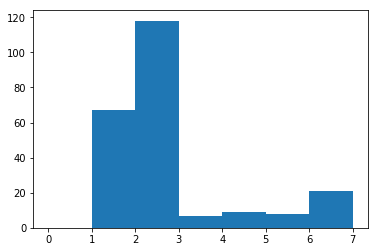

In [12]:
import matplotlib.pyplot as plt

plt.hist(train_X[:,1], bins=range(0, 8))

In [13]:
from sklearn import preprocessing

enc = preprocessing.OneHotEncoder(n_values=[24, 8])
enc.fit([[0, 0]])
train_X = enc.transform(train_X).toarray()

In [14]:
train_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [15]:
# sklearn
# from sklearn import linear_model
# from sklearn import svm

# FM http://contrib.scikit-learn.org/polylearn/index.html
# import polylearn


# clf = linear_model.LogisticRegression(C=100.0, random_state=0)
# clf = linear_model.LogisticRegressionCV()
# clf = svm.SVC(C=100, random_state=0, probability=True, gamma=0.01, decision_function_shape='ovo')
# clf = polylearn.FactorizationMachineClassifier(degree=3, loss='logistic')
# clf.fit(train_X, train_y)

FactorizationMachineClassifier(alpha=1, beta=1, degree=3, fit_linear=True,
                fit_lower='explicit', init_lambdas='ones', loss='logistic',
                max_iter=10000, n_components=2, random_state=None,
                tol=1e-06, verbose=False, warm_start=False)

In [16]:
# print(clf.coef_)
# print(clf.intercept_)

In [17]:
from mlxtend.plotting import plot_decision_regions

# plt.xlim(1, 2)
# plt.ylim(0, 1)
# plot_decision_regions(X=train_X, y=train_y, clf=clf, legend=2)

In [18]:
# 验证集
valid_X = valid_interaction_df[valid_interaction_df.user_id == user_id][['time', 'duration_time']]
valid_X['time'] = valid_X['time'].apply(to_hour)
valid_X['duration_time'] = valid_X['duration_time'].apply(to_category)
valid_X = valid_X.values
valid_X = enc.transform(valid_X).toarray()

valid_y = valid_interaction_df[valid_interaction_df.user_id == user_id]['click'].values

In [20]:
# 预测click为1的概率
# pred_y = clf.predict_proba(valid_X)[:,1]
pred_y = clf.predict_proba(valid_X)
# pred_y = clf.predict(valid_X)

In [21]:
pred_y

array([0.29754927, 0.39733182, 0.39733182, 0.43418239, 0.43418239,
       0.23865954, 0.43418239, 0.29754927, 0.53409388, 0.43418239,
       0.43418239, 0.43418239, 0.46600478, 0.53409388, 0.43418239,
       0.39733182, 0.24507764, 0.43418239, 0.43418239, 0.43418239,
       0.44977016, 0.43418239, 0.25110698, 0.12819986, 0.28917463,
       0.29754927, 0.43418239, 0.46600478, 0.27696688, 0.42474405,
       0.43418239, 0.24507764, 0.25110698, 0.39733182, 0.29754927,
       0.43418239, 0.46600478])

In [22]:
# auc评分
from sklearn import metrics
metrics.roc_auc_score(valid_y, pred_y)

0.5176282051282051

## 所有用户

使用上述方法为每个用户训练一个模型

In [99]:
# 每个用户训练一个逻辑回归模型，并导出

from sklearn.externals import joblib
import os

for user_id in train_interaction_df.user_id.unique():
    if os.path.exists('../out/pred_user_interaction_model/' + str(user_id)):
        continue
    train_X = train_interaction_df[train_interaction_df.user_id == user_id][['duration_time']]
#     train_X.time = train_X.time.apply(to_hour)
    train_X.duration_time = train_X.duration_time.apply(to_category)
    train_X = train_X.values
    train_X = enc.transform(train_X).toarray()
    train_y = train_interaction_df[train_interaction_df.user_id == user_id]['click'].values
#     clf = linear_model.LogisticRegression(C=100.0, random_state=0)
#     clf = linear_model.LogisticRegressionCV()
#     clf = svm.SVC(C=100.0, random_state=0, probability=True, decision_function_shape='ovo')
    clf = polylearn.FactorizationMachineClassifier(degree=3, loss='logistic')
    clf.fit(train_X, train_y)
    # 持久化为磁盘文件
    joblib.dump(clf, '../out/pred_user_interaction_model/' + str(user_id))
    

## 预测

In [100]:
pred_df = valid_interaction_df[['user_id', 'photo_id', 'duration_time']]
pred_df = pred_df.reindex(columns=['user_id', 'photo_id', 'duration_time', 'click_probability'])

In [101]:
pred_df.head()

,user_id,photo_id,duration_time,click_probability
21,1637,7300221,7,NaN
30,1637,7090577,15,NaN
47,1637,7427964,17,NaN
52,1637,7115682,140,NaN
56,1637,7089041,15,NaN


In [102]:
# 装载预测模型

pred_models = {}

for user_id in pred_df.user_id.unique():
    pred_models[user_id] = joblib.load('../out/pred_user_interaction_model/' + str(user_id))
    

In [103]:
# 预测函数

def predict(row):
    user_id = row.user_id
    clf = pred_models[user_id]
    pred_X = enc.transform([[to_category(row.duration_time)]]).toarray()
    pred_y = clf.predict_proba(pred_X)
#     index = np.where(clf.classes_ == 1)[0][0]
#     pred_y = pred_y[0, index]
    pred_y = pred_y[0]
#     print(pred_y)
    pred_y = round(pred_y, 6)
    return pred_y


In [104]:
# 填充click_probability列

import numpy as np

pred_df.click_probability = pred_df.apply(predict, axis = 1)


In [105]:
pred_df = pred_df[['user_id', 'photo_id', 'click_probability']]
pred_df.head()
# pred_df[pred_df.user_id == 14584]

,user_id,photo_id,click_probability
21,1637,7300221,0.230233
30,1637,7090577,0.224465
47,1637,7427964,0.224465
52,1637,7115682,0.151340
56,1637,7089041,0.224465


## 导出

In [106]:
# 导出预测结果
pred_df.to_csv('../out/pred_user_interaction.txt', index=False, header=False, sep='\t', float_format='%.6f')

In [107]:
valid_interaction_df[['user_id', 'photo_id', 'click']].to_csv('../out/valid.txt', index=False, header=False, sep='\t')

## 评分

0.7069625893799051 - 平均值法

0.7139489062279162 - time(0~23)、duration_time（0~7），lr

0.706982582265217 - duration_time（0~7），lr

0.708038438407235 - time(0~23)、duration_time（0~7），svm

0.7277412553636792 - time(0~23)、duration_time（0~7)，fm

0.7079793848125076 - duration_time（0~7)，fm

In [108]:
%run evaluation_script.py ../out/pred_user_interaction.txt ../out/valid.txt

{'code': 0, 'message': 'validation success'}
{'code': 0, 'score': 0.7079793848125076, 'message': 'success'}
